In [83]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [84]:
# Read in all the CSV files
t_skin = pd.read_csv('computed_temperature.csv')
vo2_max = pd.read_csv('demographic_vo2_max.csv')
glucose = pd.read_csv('glucose.csv')
df_hrv = pd.read_csv('heart_rate_variability_details.csv')
hormones_selfreport = pd.read_csv('hormones_and_selfreport.csv')
resting_heart_rate = pd.read_csv('resting_heart_rate.csv')



In [85]:
# Define the merge keys
merge_keys = ['id', 'study_interval', 'day_in_study']


# GLUCOSE
glucose_daily = glucose.groupby(merge_keys).agg({
    'glucose_value': ['mean', 'std', 'min', 'max']
}).reset_index()
glucose_daily.columns = ['id', 'study_interval', 'day_in_study', 
                          'glucose_mean', 'glucose_std', 'glucose_min', 'glucose_max']


# HRV
df_hrv_daily = df_hrv.groupby(merge_keys).agg({
    'rmssd': ['mean', 'std'],
    'coverage': 'mean',
    'low_frequency': 'mean',
    'high_frequency': 'mean'
}).reset_index()
df_hrv_daily.columns = ['id', 'study_interval', 'day_in_study',
                         'rmssd_mean', 'rmssd_std', 'coverage_mean', 
                         'low_freq_mean', 'high_freq_mean']


# SKIN TEMP
t_skin_clean = t_skin[['id', 'study_interval', 'sleep_start_day_in_study', 
                        'nightly_temperature', 'baseline_relative_nightly_standard_deviation']].copy()
t_skin_clean.rename(columns={'sleep_start_day_in_study': 'day_in_study'}, inplace=True)


# 6. Target variable - keep only rows with phase data
hormones_clean = hormones_selfreport[hormones_selfreport['phase'].notna()].copy()

# Start with hormones_clean as the base (only days with phase labels)
df_merged = hormones_clean[merge_keys + ['phase', 'lh', 'estrogen']].copy()

# Merge all datasets
df_merged = df_merged.merge(t_skin_clean, on=merge_keys, how='left')
df_merged = df_merged.merge(glucose_daily, on=merge_keys, how='left')
df_merged = df_merged.merge(df_hrv_daily, on=merge_keys, how='left')


# Check the merged data
print("Merged dataset shape:", df_merged.shape)
print("\nMissing values per column:")
print(df_merged.isnull().sum())
print("\nPhase distribution:")
print(df_merged['phase'].value_counts())
print("\nNumber of unique participants:", df_merged['id'].nunique())
print("\nData sample:")
print(df_merged.head())

Merged dataset shape: (6653, 17)

Missing values per column:
id                                                 0
study_interval                                     0
day_in_study                                       0
phase                                              0
lh                                               346
estrogen                                         347
nightly_temperature                             1151
baseline_relative_nightly_standard_deviation    1458
glucose_mean                                    3268
glucose_std                                     3269
glucose_min                                     3268
glucose_max                                     3268
rmssd_mean                                       870
rmssd_std                                        874
coverage_mean                                    870
low_freq_mean                                    870
high_freq_mean                                   870
dtype: int64

Phase distribution:
phas

In [86]:
# Analyze data completeness by participant
print("Data completeness analysis by participant:\n")

participant_summary = []
for participant_id in df_merged['id'].unique():
    participant_data = df_merged[df_merged['id'] == participant_id]
    
    summary = {
        'id': participant_id,
        'total_days': len(participant_data),
        'hrv_missing': participant_data['rmssd_mean'].isna().sum(),
        'temp_missing': participant_data['nightly_temperature'].isna().sum(),
        'glucose_missing': participant_data['glucose_mean'].isna().sum(),
        'lh_missing': participant_data['lh'].isna().sum(),
        'estrogen_missing': participant_data['estrogen'].isna().sum()
    }
    
    # Calculate percentages
    summary['hrv_missing_pct'] = (summary['hrv_missing'] / summary['total_days'] * 100)
    summary['temp_missing_pct'] = (summary['temp_missing'] / summary['total_days'] * 100)
    summary['glucose_missing_pct'] = (summary['glucose_missing'] / summary['total_days'] * 100)
    
    participant_summary.append(summary)

participant_df = pd.DataFrame(participant_summary)
print(participant_df.to_string())

# Identify participants to exclude (e.g., >50% missing in any key feature)
threshold = 50 # percentage
participants_to_exclude = participant_df[
    (participant_df['hrv_missing_pct'] > threshold) | 
    (participant_df['temp_missing_pct'] > threshold) |
    (participant_df['glucose_missing_pct'] > threshold)
]['id'].tolist()

print(f"\n\nParticipants to exclude (>{threshold}% missing data): {participants_to_exclude}")
print(f"Excluding {len(participants_to_exclude)} out of {len(participant_df)} participants")

# Filter dataset to exclude these participants
df_filtered = df_merged[~df_merged['id'].isin(participants_to_exclude)].copy()

print(f"\n\nDataset after filtering:")
print(f"Original: {len(df_merged)} samples from {df_merged['id'].nunique()} participants")
print(f"Filtered: {len(df_filtered)} samples from {df_filtered['id'].nunique()} participants")

print("\nMissing values after filtering:")
print(df_filtered.isnull().sum())
print("\nPercentage missing after filtering:")
print((df_filtered.isnull().sum() / len(df_filtered) * 100).round(2))

# Update df_merged to the filtered version
df_merged = df_filtered.copy()

print(f"\nPhase distribution after filtering:")
print(df_merged['phase'].value_counts())

Data completeness analysis by participant:

    id  total_days  hrv_missing  temp_missing  glucose_missing  lh_missing  estrogen_missing  hrv_missing_pct  temp_missing_pct  glucose_missing_pct
0    1          94           94            53               34           3                 3       100.000000         56.382979            36.170213
1    2         113            7            23                4           0                 0         6.194690         20.353982             3.539823
2    3          96           96            15               26           9                 9       100.000000         15.625000            27.083333
3    4          91           19            25               16          14                14        20.879121         27.472527            17.582418
4    6          94           32            31               34           9                 9        34.042553         32.978723            36.170213
5    7         102            6            14                9

In [87]:
# Feature columns
feature_cols = ['nightly_temperature', 'glucose_mean', 'rmssd_mean']

X = df_merged[feature_cols].copy()
y = df_merged['phase'].copy()


print(f"Features before imputation:")
print(f"Shape: {X.shape}")
print(f"Missing values:\n{X.isnull().sum()}")

# Impute per participant to avoid data leakage
print("\n" + "="*80)
print("Applying IterativeImputer per participant...")
print("="*80)

X_imputed = X.copy()

for participant_id in df_merged['id'].unique():
    # Get mask for this participant
    participant_mask = df_merged['id'] == participant_id
    
    # Get participant data
    participant_X = X[participant_mask].copy()
    
    # Only impute if there are missing values for this participant
    if participant_X.isnull().any().any():
        # Check if participant has enough data to impute
        if len(participant_X) > 1 and not participant_X.isnull().all().any():
            iterative_imputer = IterativeImputer(
                max_iter=10,
                random_state=42,
                verbose=0,
                initial_strategy='median'
            )
            
            # Impute for this participant
            X_imputed.loc[participant_mask, feature_cols] = iterative_imputer.fit_transform(participant_X)
            print(f"Imputed participant {participant_id}: {participant_X.isnull().sum().sum()} missing values")
        else:
            # If not enough data, use simple median imputation from this participant's data
            for col in feature_cols:
                if participant_X[col].isnull().any():
                    # Use participant's median, or overall median if all values are missing
                    participant_median = participant_X[col].median()
                    if pd.isna(participant_median):
                        participant_median = X[col].median()
                    X_imputed.loc[participant_mask, col] = participant_X[col].fillna(participant_median)
            print(f"Simple imputation for participant {participant_id}: insufficient data for iterative imputation")

print("\nImputation complete!")
print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")

# Verify no missing values remain
if X_imputed.isnull().sum().sum() > 0:
    print("\nWarning: Still have missing values. Filling with overall median...")
    from sklearn.impute import SimpleImputer
    simple_imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        simple_imputer.fit_transform(X_imputed),
        columns=feature_cols,
        index=X_imputed.index
    )

assert X_imputed.isnull().sum().sum() == 0, "Still have missing values after imputation!"

print("\n" + "="*80)
print("Dataset ready for modeling:")
print("="*80)
print(f"Samples: {len(X_imputed)}")
print(f"Features: {len(feature_cols)}")


# Split data by participant
participant_ids = df_merged['id'].values
unique_ids = df_merged['id'].unique()

# Create train/test split by participant
np.random.seed(42)
train_ids = np.random.choice(unique_ids, size=int(0.8 * len(unique_ids)), replace=False)
test_mask = ~df_merged['id'].isin(train_ids)
train_mask = df_merged['id'].isin(train_ids)

X_train = X_imputed[train_mask]
X_test = X_imputed[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Train set: {len(X_train)} samples from {len(train_ids)} participants")
print(f"Test set: {len(X_test)} samples from {len(unique_ids) - len(train_ids)} participants")
print(f"\nTrain phase distribution:\n{y_train.value_counts()}")
print(f"\nTest phase distribution:\n{y_test.value_counts()}")

Features before imputation:
Shape: (1659, 3)
Missing values:
nightly_temperature    327
glucose_mean           238
rmssd_mean             244
dtype: int64

Applying IterativeImputer per participant...
Imputed participant 2: 34 missing values
Imputed participant 4: 60 missing values
Imputed participant 6: 97 missing values
Imputed participant 7: 29 missing values
Imputed participant 8: 82 missing values
Imputed participant 11: 24 missing values
Imputed participant 15: 13 missing values
Imputed participant 16: 32 missing values
Imputed participant 19: 22 missing values
Imputed participant 23: 118 missing values
Imputed participant 24: 25 missing values
Imputed participant 34: 24 missing values
Imputed participant 37: 33 missing values
Imputed participant 39: 13 missing values
Imputed participant 40: 98 missing values
Imputed participant 44: 93 missing values
Imputed participant 45: 12 missing values

Imputation complete!
Missing values after imputation: 0

Dataset ready for modeling:
Sam


Train accuracy: 0.702
Test accuracy: 0.352

Classification Report:
              precision    recall  f1-score   support

   Fertility       0.19      0.17      0.18        88
  Follicular       0.29      0.17      0.22        86
      Luteal       0.49      0.62      0.55       142
   Menstrual       0.25      0.26      0.25        76

    accuracy                           0.35       392
   macro avg       0.30      0.31      0.30       392
weighted avg       0.33      0.35      0.34       392



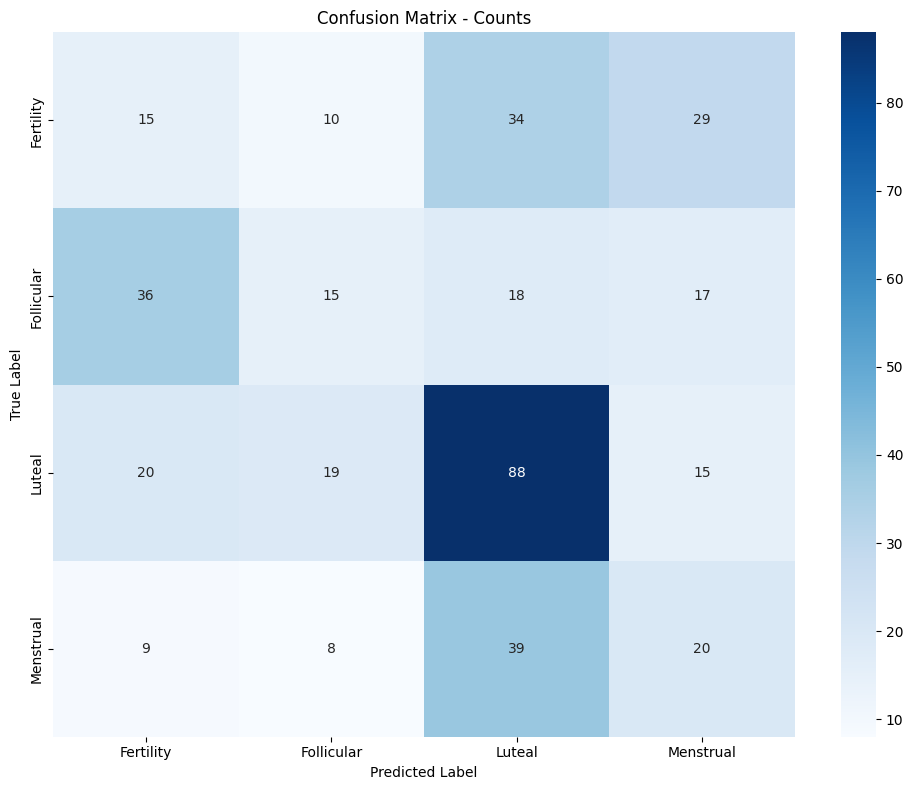

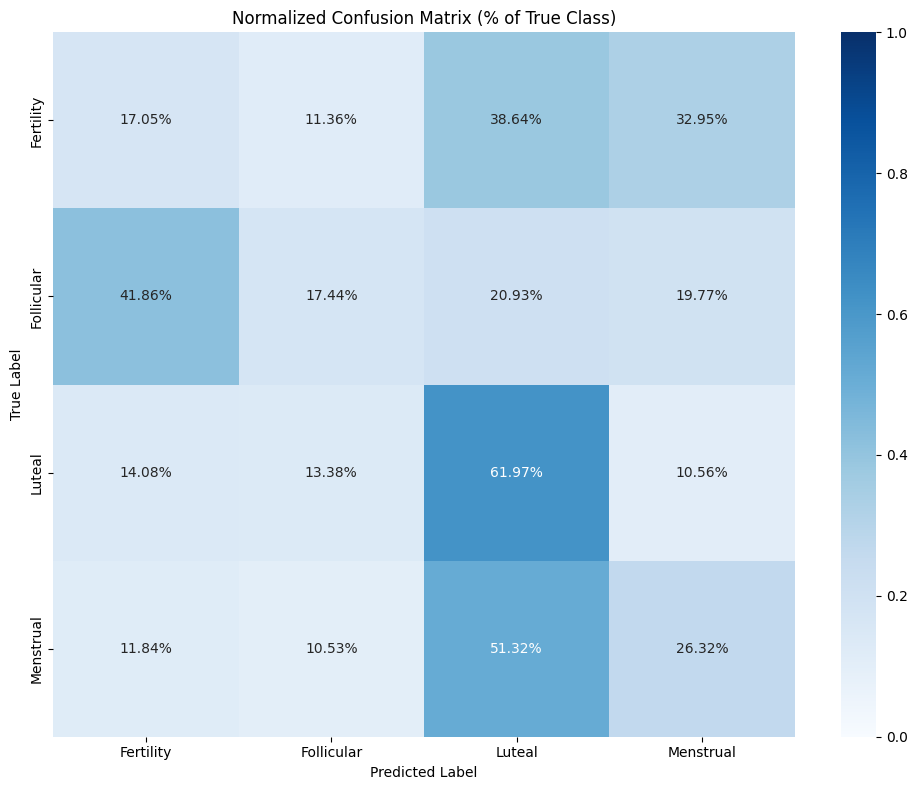


Feature Importance:
               feature  importance
2           rmssd_mean    0.340553
0  nightly_temperature    0.335919
1         glucose_mean    0.323528


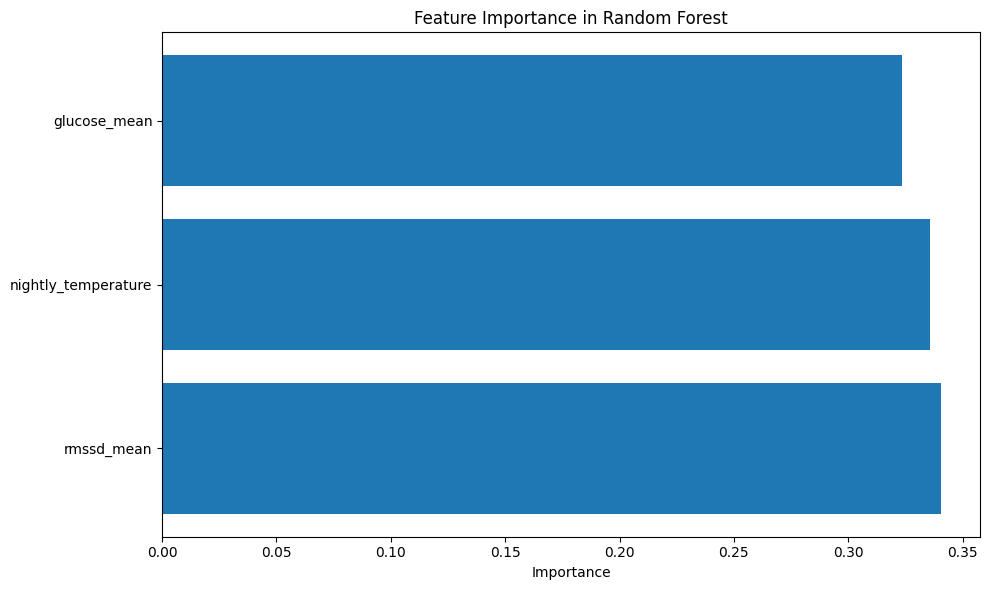

In [88]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

rf.fit(X_train, y_train)

# Evaluate
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"\nTrain accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

# Predictions
y_pred = rf.predict(X_test)

# Classification report
print("\n" + "="*80)
print("Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred))

# Get unique phases for labels
phase_labels = sorted(y.unique())

# Regular confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=phase_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=phase_labels,
            yticklabels=phase_labels)
plt.title('Confusion Matrix - Counts')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Normalized confusion matrix (shows percentages per true class)
cm_normalized = confusion_matrix(y_test, y_pred, labels=phase_labels, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=phase_labels,
            yticklabels=phase_labels,
            vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (% of True Class)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("Feature Importance:")
print("="*80)
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.tight_layout()
plt.show()
